### Imports

In [23]:
import torch
import torchvision
from torchvision.datasets import MNIST

## Download Data

In [24]:
path = '/content/drive/MyDrive/PyTorch Practice/Data/'
dataset = MNIST(path, download=True)

In [25]:
len(dataset)

60000

### Test

In [26]:
test_dataset = MNIST(path, train=False)
len(test_dataset)

10000

### Visualize sample

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


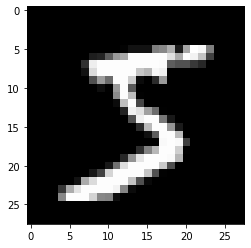

In [28]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

### Convert images into tensors

In [29]:
from torchvision.transforms import ToTensor

dataset = MNIST(path,
                train=True,
                transform=ToTensor())

In [30]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


## Validation Split

### Indices Permutation

In [31]:
import numpy as np
np.random.seed(13)

def split_indices(n, val_size=0.33):
    # Size of validation set
    n_val = int(n * val_size)
    # Random permutation of indices
    idxs = np.random.permutation(n)
    # First n_val samples are validation set
    return idxs[n_val:], idxs[:n_val]

In [32]:
train_indices, val_indices = split_indices(len(dataset), val_size=0.2)
print(len(train_indices), len(val_indices))

48000 12000


### Data Sampler & Loader

In [33]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader


batch_size = 100

# Training
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset,
                          batch_size,
                          sampler=train_sampler)

# Validation
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset,
                        batch_size,
                        sampler=val_sampler)

## Model

In [34]:
from torch import nn

input_size = 28*28
num_classes = 10

In [35]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out

model = MnistModel()

### Loss, metric, optimizer

In [36]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

In [37]:
from torch.optim import SGD

learning_rate = 0.01
optimizer = SGD(model.parameters(), lr=learning_rate)

### Loss Batch

**loss_batch:**

*   calculates the loss for a batch of data
*   perform the GD update step if optimizer is provided
*   computes a metric if provided



In [38]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Calculate loss
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        # Compute Gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients
        opt.zero_grad()

    metric_res = None
    if metric is not None:
        metric_res = metric(preds, yb)

    return loss.item(), len(xb), metric_res

We don't need to compute the gradients so we use *torch.no_grad()*

In [39]:
def evaluate(model, loss_func, val_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_func, xb, yb, metric=metric)
                   for xb, yb in val_dl]
        # Separate losses, counts and metrics
        losses, counts, metrics = zip(*results)
        # Total size
        total_size = np.sum(counts)
        # Average loss
        avg_loss = np.sum(np.multiply(losses, counts)) / total_size

        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, counts)) / total_size

        return avg_loss, total_size, avg_metric

Metric

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

Let's see how the model performs on the validation set with the initial parameters

In [41]:
val_loss, total_size, val_acc = evaluate(model, loss_fn,
                                         val_loader,
                                         metric=accuracy)
print(f'Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

Loss: 2.3361, Accuracy: 0.0898


### Train

In [42]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        # Training
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_func, xb, yb, opt=opt)

        # Evaluation
        result = evaluate(model, loss_func, valid_dl, metric)
        val_loss, total_size, val_metric = result

        # Display progress
        progress = f'Epoch {epoch+1}/{epochs}, Loss: {val_loss:.4f}'
        if metric is not None:
            progress += f', {metric.__name__}: {val_metric:.4f}'

        print(progress)

In [43]:
# Main
model = MnistModel()
optimizer = SGD(model.parameters(), lr=0.001)

In [44]:
fit(10, model, loss_fn, optimizer, train_loader, val_loader, metric=accuracy)

Epoch 1/10, Loss: 1.8759, accuracy: 0.6617
Epoch 2/10, Loss: 1.5771, accuracy: 0.7475
Epoch 3/10, Loss: 1.3678, accuracy: 0.7823
Epoch 4/10, Loss: 1.2175, accuracy: 0.7996
Epoch 5/10, Loss: 1.1059, accuracy: 0.8113
Epoch 6/10, Loss: 1.0203, accuracy: 0.8197
Epoch 7/10, Loss: 0.9529, accuracy: 0.8260
Epoch 8/10, Loss: 0.8984, accuracy: 0.8297
Epoch 9/10, Loss: 0.8534, accuracy: 0.8336
Epoch 10/10, Loss: 0.8155, accuracy: 0.8382


## Predictions

In [47]:
test_dataset = MNIST(path,
                     train=False,
                     transform=ToTensor())
len(test_dataset)

10000

*img.unsqueeze()* simply adds another dimension at the beginning

In [45]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 0, Prediction: 0


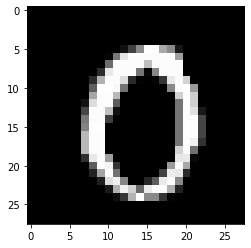

In [49]:
img, label = test_dataset[13]
plt.imshow(img[0], cmap='gray')
print(f'Label: {label}, Prediction: {predict_image(img, model)}')

### Total score on Test

In [50]:
test_loader = DataLoader(test_dataset,
                         batch_size=200)
test_loss, _, test_acc = evaluate(model, loss_fn, test_loader,
                                  metric=accuracy)
print(f'Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

Loss: 0.7891, Accuracy: 0.8483


## Save Model

We save weights (state) of the model

In [51]:
path = '/content/drive/MyDrive/PyTorch Practice/Models/'
file_name = 'mnist-logistic.pth'
torch.save(model.state_dict(), path + file_name)

In [52]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0099, -0.0035, -0.0309,  ...,  0.0072,  0.0170, -0.0163],
                      [-0.0240,  0.0148,  0.0290,  ..., -0.0106,  0.0008, -0.0096],
                      [-0.0100, -0.0061, -0.0257,  ..., -0.0100, -0.0013, -0.0173],
                      ...,
                      [ 0.0143,  0.0207,  0.0334,  ...,  0.0224, -0.0006, -0.0141],
                      [-0.0156, -0.0182,  0.0138,  ...,  0.0030, -0.0286,  0.0268],
                      [ 0.0187,  0.0071, -0.0146,  ..., -0.0152, -0.0034, -0.0080]])),
             ('linear.bias',
              tensor([-0.0325,  0.0482, -0.0373, -0.0249,  0.0161,  0.0576,  0.0019,  0.0416,
                      -0.0852,  0.0068]))])

### Load Model

In [53]:
path = '/content/drive/MyDrive/PyTorch Practice/Models/'
file_name = 'mnist-logistic.pth'

model2 = MnistModel()
model2.load_state_dict(torch.load(path + file_name))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0099, -0.0035, -0.0309,  ...,  0.0072,  0.0170, -0.0163],
                      [-0.0240,  0.0148,  0.0290,  ..., -0.0106,  0.0008, -0.0096],
                      [-0.0100, -0.0061, -0.0257,  ..., -0.0100, -0.0013, -0.0173],
                      ...,
                      [ 0.0143,  0.0207,  0.0334,  ...,  0.0224, -0.0006, -0.0141],
                      [-0.0156, -0.0182,  0.0138,  ...,  0.0030, -0.0286,  0.0268],
                      [ 0.0187,  0.0071, -0.0146,  ..., -0.0152, -0.0034, -0.0080]])),
             ('linear.bias',
              tensor([-0.0325,  0.0482, -0.0373, -0.0249,  0.0161,  0.0576,  0.0019,  0.0416,
                      -0.0852,  0.0068]))])

Sanity check

In [54]:
test_loader = DataLoader(test_dataset,
                         batch_size=200)
test_loss, _, test_acc = evaluate(model2, loss_fn, test_loader,
                                  metric=accuracy)
print(f'Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')

Loss: 0.7891, Accuracy: 0.8483
